In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Cargar datos
accepted = pd.read_csv('accepted_2007_to_2018Q4.csv')
rejected = pd.read_csv('rejected_2007_to_2018Q4.csv')

C:\Users\Alan1\AppData\Local\Temp\ipykernel_21760\4048834724.py:8: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  accepted = pd.read_csv('accepted_2007_to_2018Q4.csv')


### 2. A Análisis Descriptivo – ¿Qué está pasando?

En esta sección vamos a:

1. Cargar las bases de **préstamos aceptados**.
2. Hacer una **limpieza básica**.
3. Analizar la **distribución de préstamos** por:
   - Grado de riesgo: `grade` / `sub_grade`
   - Propósito del préstamo: `purpose`
4. Calcular la **proporción de préstamos** por estado:
   - `Fully Paid`, `Charged Off`, estados de mora (`Late`, `Default`, etc.).
5. Explorar las **características de buenos pagadores** (mejor repago):
   - Ingreso anual (`annual_inc`)
   - Score (`fico_range_low` / `fico_range_high`)
   - Deuda / ingreso (`dti`)


#### 2.A.1 Limpieza inicial de la base de aceptados

Antes de analizar, limpiamos:

- Filtramos solo las columnas relevantes para riesgo y descriptivo.
- Eliminamos registros con **nulos críticos** (por ejemplo, sin `grade`, `loan_status`, `annual_inc`, `dti`, `fico`).
- Creamos variables derivadas:
  - `fico_score` = promedio de `fico_range_low` y `fico_range_high`.
- Tratamos **outliers** en:
  - `annual_inc` (ingreso anual)
  - `dti` (deuda/ingreso)
  usando winsorización simple (recortar al percentil 1 y 99).


In [2]:
# ============================================
# 2. SELECCIÓN DE COLUMNAS CLAVE Y LIMPIEZA
# ============================================

cols_keep = [
    "loan_amnt",
    "funded_amnt",
    "term",
    "int_rate",
    "installment",
    "grade",
    "sub_grade",
    "emp_length",
    "home_ownership",
    "annual_inc",
    "verification_status",
    "issue_d",
    "loan_status",
    "purpose",
    "dti",
    "earliest_cr_line",
    "fico_range_low",
    "fico_range_high",
    "recoveries",
    "total_pymnt",
    "total_rec_prncp",
    "total_rec_int"
]

# Nos quedamos solo con esas columnas (las que existan)
cols_exist = [c for c in cols_keep if c in accepted.columns]
accepted_small = accepted[cols_exist].copy()

# Crear score promedio FICO
if {"fico_range_low", "fico_range_high"}.issubset(accepted_small.columns):
    accepted_small["fico_score"] = accepted_small[["fico_range_low", "fico_range_high"]].mean(axis=1)

# Convertir tasa de interés de string "13.56%" a float 13.56 si viene así
if accepted_small["int_rate"].dtype == "O":
    accepted_small["int_rate"] = (
        accepted_small["int_rate"]
        .str.replace("%", "", regex=False)
        .astype(float)
    )

# Quitar registros con nulos críticos
critical_cols = ["grade", "loan_status", "purpose", "annual_inc", "dti"]
critical_cols = [c for c in critical_cols if c in accepted_small.columns]

accepted_clean = accepted_small.dropna(subset=critical_cols).copy()

# Eliminamos ingresos no positivos o DTI negativos
accepted_clean = accepted_clean[
    (accepted_clean["annual_inc"] > 0) & (accepted_clean["dti"] >= 0)
].copy()

# ============================================
# 2.1 TRATAMIENTO BÁSICO DE OUTLIERS (WINSORIZACIÓN)
# ============================================

def winsorize_series(s, lower=0.01, upper=0.99):
    """Recorta una serie en los percentiles inferior/superior indicados."""
    q_low = s.quantile(lower)
    q_high = s.quantile(upper)
    return s.clip(lower=q_low, upper=q_high)

for col in ["annual_inc", "dti", "fico_score"]:
    if col in accepted_clean.columns:
        accepted_clean[col] = winsorize_series(accepted_clean[col])

accepted_clean.shape


(2258943, 23)

#### 2.A.2 Distribución de préstamos por grado de riesgo y propósito

Aquí analizamos:

- Cómo se distribuyen los préstamos por **grade** y **sub_grade**.
- Para qué **propósito** se solicitan (deuda, auto, casa, educación, etc.).
- Esto nos ayuda a entender el **apetito de riesgo** del portafolio y los usos más comunes del crédito.


,grade,n_prestamos
0,A,432734
1,B,663118
2,C,649539
3,D,324091
4,E,135538
5,F,41772
6,G,12151


,grade,sub_grade,n_prestamos
0,A,A1,86719
1,A,A2,69520
2,A,A3,73129
3,A,A4,95803
4,A,A5,107563
5,B,B1,125253
6,B,B2,126535
7,B,B3,131433
8,B,B4,139703
9,B,B5,140194


,purpose,n_prestamos
2,debt_consolidation,1276877
1,credit_card,516636
4,home_improvement,150313
9,other,139328
6,major_purchase,50415
7,medical,27460
11,small_business,24672
0,car,24002
12,vacation,15520
8,moving,15372


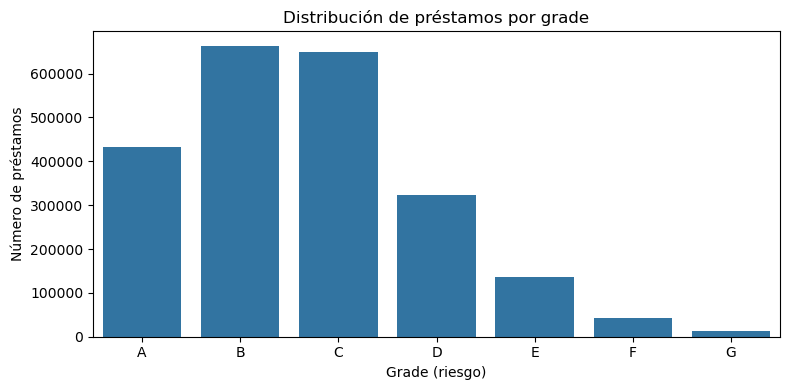

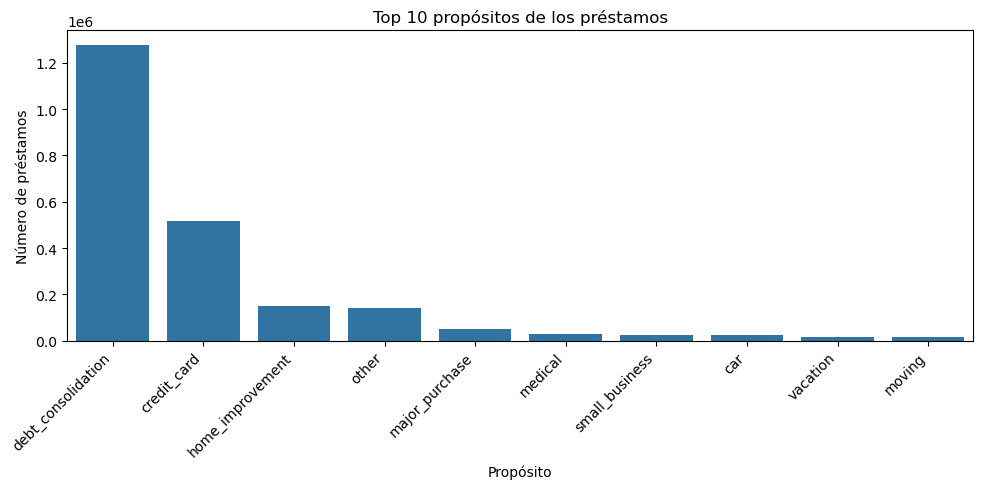

In [3]:
# ============================================
# 3. DISTRIBUCIÓN POR GRADE / SUB_GRADE / PURPOSE
# ============================================

# Conteo simple por grade
grade_counts = (
    accepted_clean
    .groupby("grade")
    .size()
    .reset_index(name="n_prestamos")
    .sort_values("grade")
)

display(grade_counts)

# Conteo por grade y sub_grade
if "sub_grade" in accepted_clean.columns:
    subgrade_counts = (
        accepted_clean
        .groupby(["grade", "sub_grade"])
        .size()
        .reset_index(name="n_prestamos")
        .sort_values(["grade", "sub_grade"])
    )
    display(subgrade_counts.head(20))

# Conteo por propósito
purpose_counts = (
    accepted_clean
    .groupby("purpose")
    .size()
    .reset_index(name="n_prestamos")
    .sort_values("n_prestamos", ascending=False)
)

display(purpose_counts.head(20))

# Visualización: distribución por grade
plt.figure(figsize=(8,4))
sns.barplot(data=grade_counts, x="grade", y="n_prestamos")
plt.title("Distribución de préstamos por grade")
plt.xlabel("Grade (riesgo)")
plt.ylabel("Número de préstamos")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Visualización: top 10 propósitos
top_purposes = purpose_counts.head(10)

plt.figure(figsize=(10,5))
sns.barplot(data=top_purposes, x="purpose", y="n_prestamos")
plt.title("Top 10 propósitos de los préstamos")
plt.xlabel("Propósito")
plt.ylabel("Número de préstamos")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


#### 2.A.3 Proporción de préstamos por estado (Fully Paid, Charged Off, Late…)

Ahora analizamos la salud de la cartera:

- ¿Qué porcentaje de los préstamos han sido **pagados completamente**?
- ¿Qué porcentaje está en **mora** (`Charged Off`, `Late`, `Default`, etc.)?
- ¿Qué parte sigue **vigente** (`Current`, `In Grace Period`)?

Agrupamos los distintos textos de `loan_status` en tres grandes categorías:
- `good`  → pagados totalmente.
- `bad`   → impago/mora.
- `other` → vigentes o estados intermedios.


,status_simple,n_prestamos,porcentaje
0,bad,295076,13.062570
1,good,1078430,47.740470
2,other,885437,39.196961


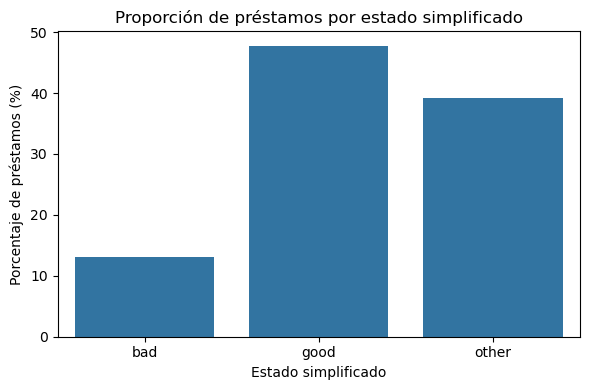

In [4]:
# ============================================
# 4. PROPORCIÓN DE PRÉSTAMOS POR ESTADO
# ============================================

accepted_clean["loan_status"].value_counts().head(10)

def simplify_status(status):
    status = str(status)
    status_lower = status.lower()
    
    if "fully paid".lower() in status_lower:
        return "good"  # buen historial
    if ("charged off" in status_lower) or ("default" in status_lower) or ("does not meet" in status_lower):
        return "bad"   # pérdida / alto riesgo
    if "late" in status_lower:
        return "bad"   # consideramos late como mora
    # El resto lo dejamos como "other" (vigentes, en gracia, etc.)
    return "other"

accepted_clean["status_simple"] = accepted_clean["loan_status"].apply(simplify_status)

status_counts = (
    accepted_clean
    .groupby("status_simple")
    .size()
    .reset_index(name="n_prestamos")
)

status_counts["porcentaje"] = status_counts["n_prestamos"] / status_counts["n_prestamos"].sum() * 100

display(status_counts)

plt.figure(figsize=(6,4))
sns.barplot(data=status_counts, x="status_simple", y="porcentaje")
plt.title("Proporción de préstamos por estado simplificado")
plt.xlabel("Estado simplificado")
plt.ylabel("Porcentaje de préstamos (%)")
plt.tight_layout()
plt.show()


#### 2.A.4 Perfil de clientes con mejores tasas de repago (buenos pagadores)

Definimos como “buen pagador” a los clientes cuyo préstamo está en estado **`Fully Paid`**.

Comparamos sus características frente a los clientes con **malo desempeño** (`Charged Off`, `Late`, `Default`):

- Ingreso anual (`annual_inc`)
- Score (`fico_score`)
- DTI (`dti`)

Esto nos ayuda a responder:

> “¿Cómo se ve el cliente típico que paga bien versus el que entra en mora?”


status_group         Fully Paid  Mora / Pérdida
annual_inc mean    76143.313610    69952.847304
           median  65000.000000    60000.000000
dti        mean       17.692427       19.930601
           median     17.100000       19.670000
fico_score mean      700.140176      690.209326
           median    692.000000      682.000000

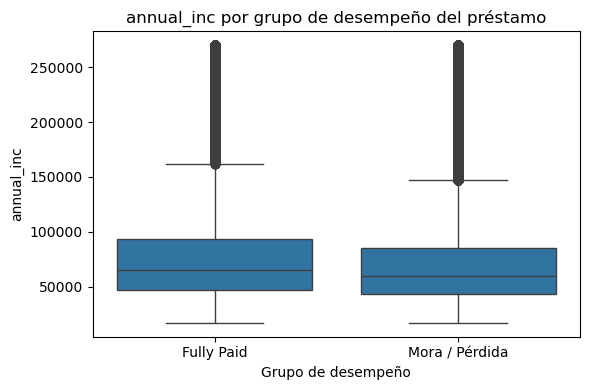

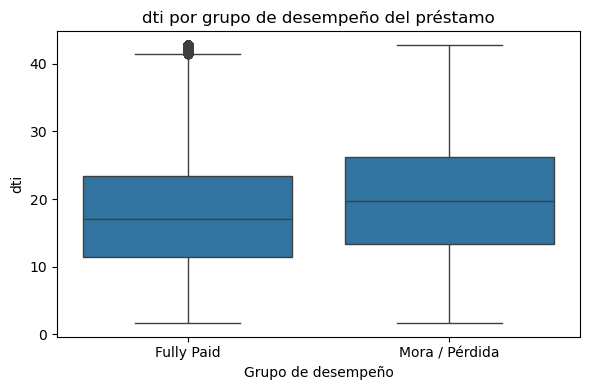

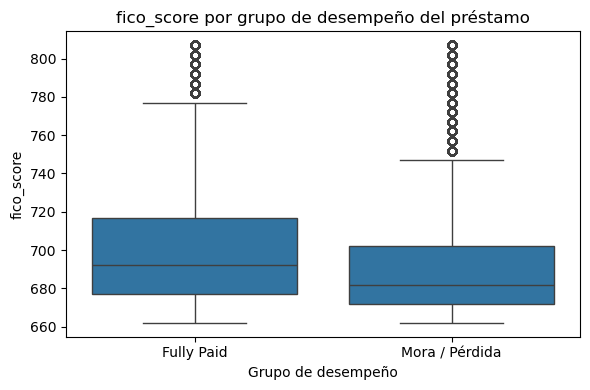

In [5]:
# ============================================
# 5. PERFIL DE BUENOS PAGADORES
# ============================================

# Creamos grupos más específicos: Fully Paid vs Charged Off / Default / Late
def status_good_bad(status):
    status = str(status).lower()
    if "fully paid" in status:
        return "Fully Paid"
    if ("charged off" in status) or ("default" in status) or ("late" in status):
        return "Mora / Pérdida"
    return "Otros"

accepted_clean["status_group"] = accepted_clean["loan_status"].apply(status_good_bad)

# Nos quedamos solo con Fully Paid y Mora/Pérdida para el comparativo
mask = accepted_clean["status_group"].isin(["Fully Paid", "Mora / Pérdida"])
comparison = accepted_clean[mask].copy()

vars_riesgo = ["annual_inc", "dti", "fico_score"]
vars_riesgo = [v for v in vars_riesgo if v in comparison.columns]

perfil_stats = (
    comparison
    .groupby("status_group")[vars_riesgo]
    .agg(["mean", "median"])
    .T  # transponemos para verlo más fácil
)

display(perfil_stats)

# Boxplots comparativos
for col in vars_riesgo:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=comparison, x="status_group", y=col)
    plt.title(f"{col} por grupo de desempeño del préstamo")
    plt.xlabel("Grupo de desempeño")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


### 2.B Análisis Diagnóstico – ¿Por qué ocurre?

En esta sección buscamos explicar **por qué** ciertos clientes caen en mora o pérdida.  
Para ello analizaremos:

1. **Factores relacionados con el impago**
   - Correlaciones entre variables financieras (DTI, ingreso, score, interés).
   - Diferencias entre segmentos (propósito, grade, home ownership).
   - Relación entre grado de riesgo (`grade`) y desempeño real.

2. **Impacto de tasas, DTI e ingreso en el rendimiento**
   - ¿Las tasas más altas se asocian a mayor impago?
   - ¿Los clientes con mayor DTI presentan peor desempeño?
   - ¿Los ingresos bajos explican defaults?

3. **Diferencias entre segmentos**
   - Por propósito (deuda, auto, hogar…)
   - Por riesgo (A, B, C, etc.).
   - Por nivel de ingreso.

Este análisis nos prepara para el modelado explicativo (regresiones).


In [6]:
# Copiamos el dataset limpio para trabajar
df = accepted_clean.copy()

# Aseguramos variables numéricas clave
num_vars = ["loan_amnt", "int_rate", "annual_inc", "dti", "fico_score", "installment"]
num_vars = [c for c in num_vars if c in df.columns]

df[num_vars].describe().T


,count,mean,std,min,25%,50%,75%,max
loan_amnt,2258943.0,15043.858389,9188.066743,500.00,8000.00,12900.00,20000.00,40000.00
int_rate,2258943.0,13.091966,4.831394,5.31,9.49,12.62,15.99,30.99
annual_inc,2258943.0,76260.065865,44524.457812,17000.00,46000.00,65000.00,93000.00,270000.00
dti,2258943.0,18.485206,8.819277,1.72,11.89,17.84,24.49,42.71
fico_score,2258943.0,700.472049,32.611002,662.00,677.00,692.00,717.00,807.00
installment,2258943.0,445.725541,267.109687,4.93,251.61,377.89,593.06,1719.83


In [7]:
# Creamos variable binaria: 1 = impago/mora, 0 = buen pagador
df["bad_flag"] = df["status_simple"].apply(lambda x: 1 if x == "bad" else 0)

# Correlación de variables financieras contra impago
corr = df[num_vars + ["bad_flag"]].corr()   ["bad_flag"].sort_values(ascending=False)
corr


bad_flag       1.000000
int_rate       0.209059
dti            0.063528
installment    0.032261
loan_amnt      0.026639
annual_inc    -0.054910
fico_score    -0.121986
Name: bad_flag, dtype: float64

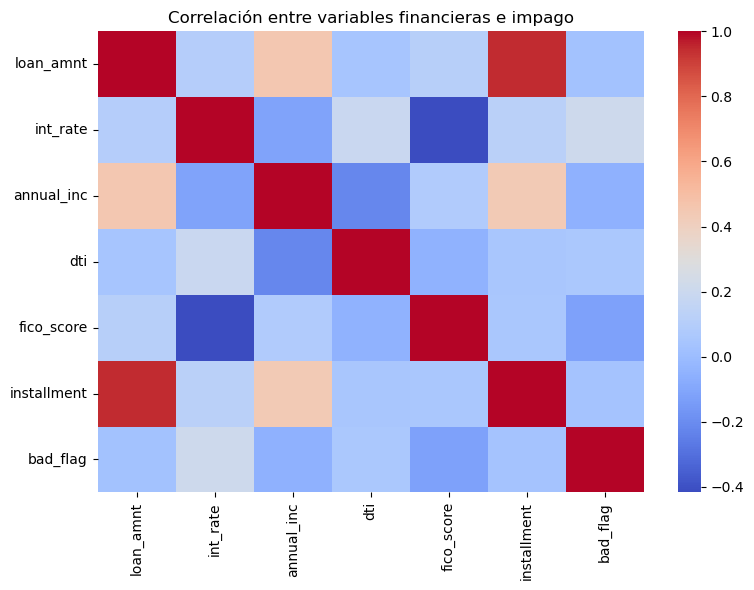

In [8]:
plt.figure(figsize=(8,6))
sns.heatmap(df[num_vars + ["bad_flag"]].corr(), annot=False, cmap="coolwarm")
plt.title("Correlación entre variables financieras e impago")
plt.tight_layout()
plt.show()


status_simple,bad,good,other
loan_amnt,15675.297381,14123.907695,15953.894828
int_rate,15.697697,12.625282,12.791999
annual_inc,69952.847304,76143.313610,78504.175789
dti,19.930601,17.692427,18.969098
fico_score,690.209326,700.140176,704.296358
installment,467.956390,431.041195,456.202006


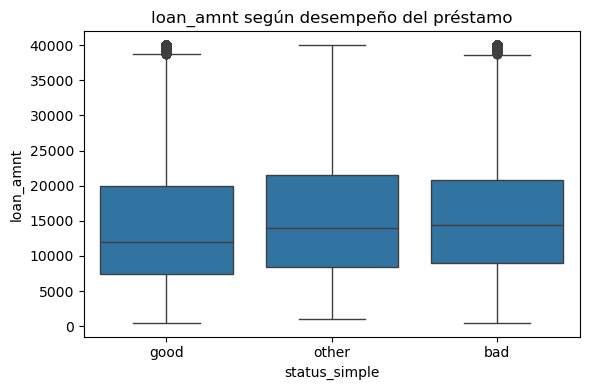

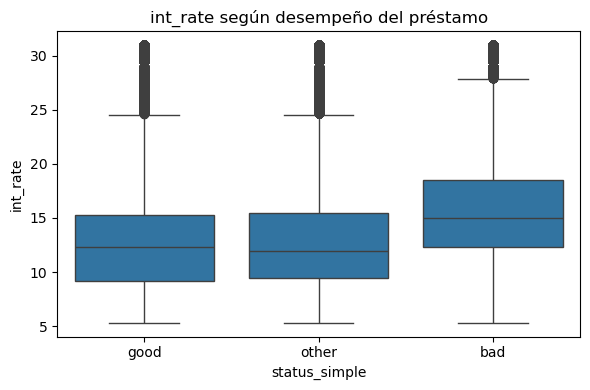

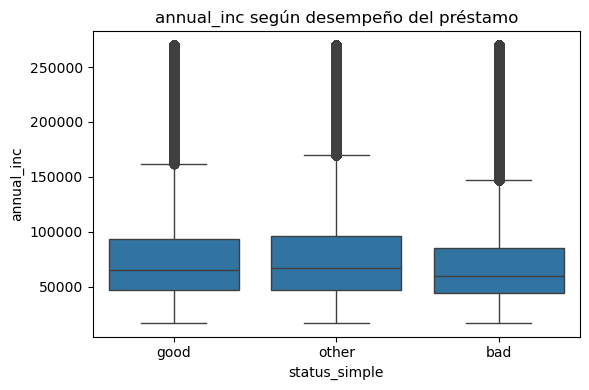

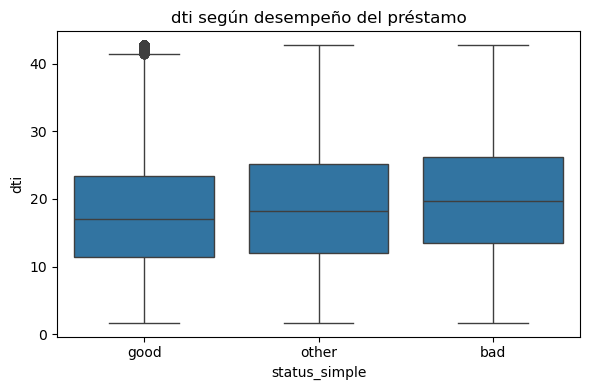

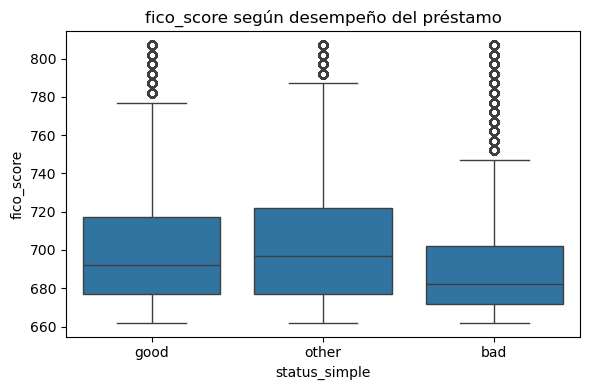

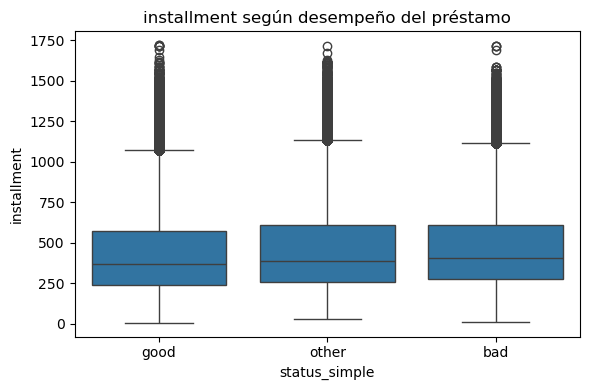

In [9]:
group_stats = df.groupby("status_simple")[num_vars].mean().T
display(group_stats)

# Boxplots por cada variable
for col in num_vars:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df, x="status_simple", y=col)
    plt.title(f"{col} según desempeño del préstamo")
    plt.tight_layout()
    plt.show()


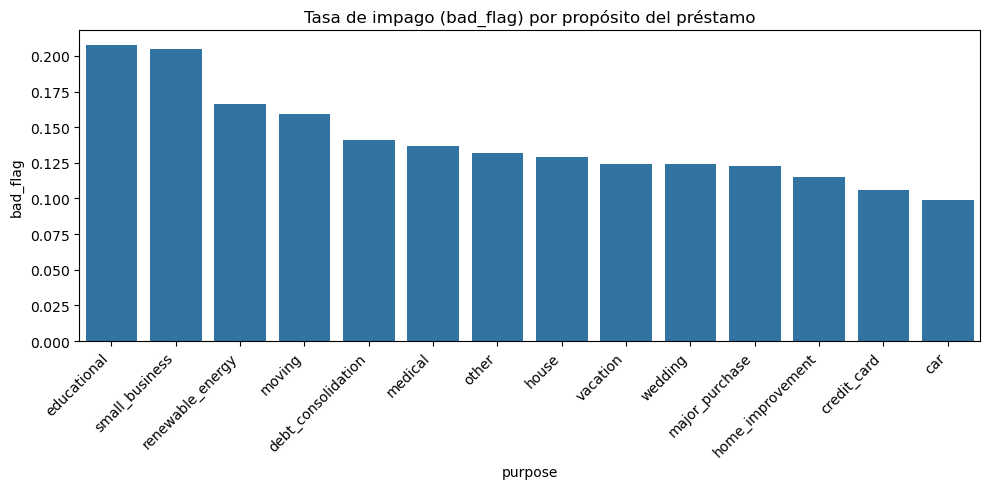

,purpose,bad_flag
3,educational,0.207547
11,small_business,0.205050
10,renewable_energy,0.166205
8,moving,0.159316
2,debt_consolidation,0.141169
7,medical,0.136672
9,other,0.132184
5,house,0.129345
12,vacation,0.124291
13,wedding,0.123992


In [10]:
purpose_bad = (
    df.groupby("purpose")["bad_flag"]
    .mean()
    .reset_index()
    .sort_values("bad_flag", ascending=False)
)

plt.figure(figsize=(10,5))
sns.barplot(data=purpose_bad, x="purpose", y="bad_flag")
plt.xticks(rotation=45, ha="right")
plt.title("Tasa de impago (bad_flag) por propósito del préstamo")
plt.tight_layout()
plt.show()

display(purpose_bad.head(10))


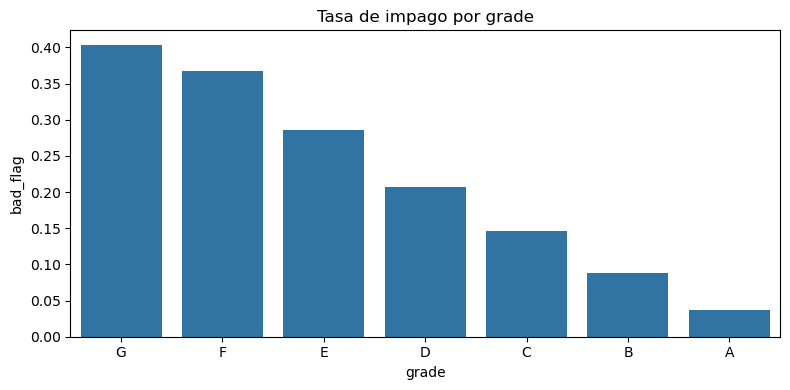

,grade,bad_flag
6,G,0.403506
5,F,0.367447
4,E,0.285957
3,D,0.206630
2,C,0.145942
1,B,0.088111
0,A,0.036688


In [11]:
grade_bad = (
    df.groupby("grade")["bad_flag"]
    .mean()
    .reset_index()
    .sort_values("bad_flag", ascending=False)
)

plt.figure(figsize=(8,4))
sns.barplot(data=grade_bad, x="grade", y="bad_flag")
plt.title("Tasa de impago por grade")
plt.tight_layout()
plt.show()

grade_bad


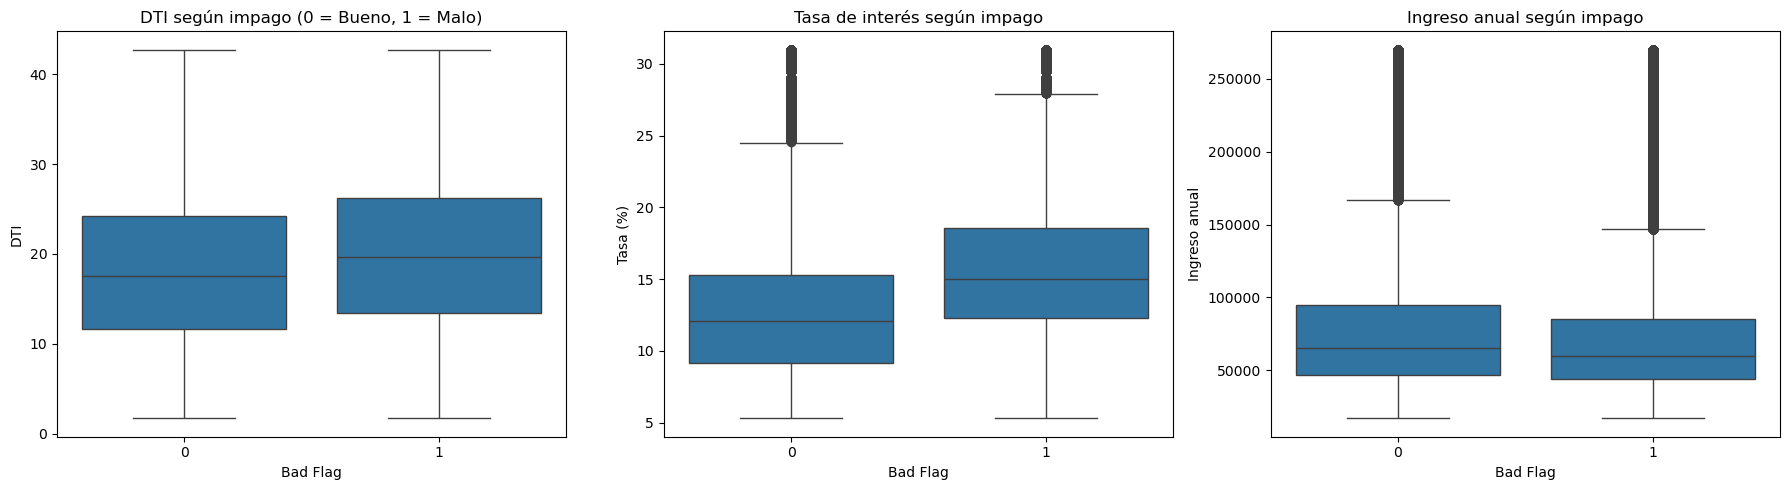

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))

sns.boxplot(data=df, x="bad_flag", y="dti", ax=axes[0])
axes[0].set_title("DTI según impago (0 = Bueno, 1 = Malo)")
axes[0].set_xlabel("Bad Flag")
axes[0].set_ylabel("DTI")

sns.boxplot(data=df, x="bad_flag", y="int_rate", ax=axes[1])
axes[1].set_title("Tasa de interés según impago")
axes[1].set_xlabel("Bad Flag")
axes[1].set_ylabel("Tasa (%)")

sns.boxplot(data=df, x="bad_flag", y="annual_inc", ax=axes[2])
axes[2].set_title("Ingreso anual según impago")
axes[2].set_xlabel("Bad Flag")
axes[2].set_ylabel("Ingreso anual")

plt.tight_layout()
plt.show()


Los boxplots muestran un patrón claro: los clientes que caen en mora (bad_flag = 1)
presentan niveles más altos de DTI, pagan tasas más elevadas y tienen ingresos más bajos.
Esto confirma que el sobreendeudamiento y la capacidad de pago limitada son detonantes
directos de la morosidad en Lending Club.


### 2.C Análisis Explicativo – ¿Qué variables influyen más?

En esta sección queremos cuantificar **qué variables explican mejor**:

1. El **rendimiento del préstamo (yield)** → modelo de **regresión lineal**.
2. La **probabilidad de impago (bad_flag)** → modelo de **regresión logística**.

Nos enfocaremos en variables financieras clave:

- `int_rate` (tasa de interés)
- `dti` (deuda/ingreso)
- `fico_score` (score promedio)
- `annual_inc` (ingreso anual)
- `loan_amnt` (monto del préstamo)
- `grade` (riesgo, transformado a numérico)
- `term` (plazo, en meses)

La idea no es “optimizar modelos”, sino **interpretar coeficientes** para responder:

> ¿Qué tanto aumenta el riesgo de impago si sube el DTI?  
> ¿Qué tanto cambia el rendimiento si sube la tasa o baja el score?


In [13]:
# ======================================================
# 1. Preparación del dataset para modelado
# ======================================================

df = accepted_clean.copy()

# Crear variable binaria de riesgo
df["bad_flag"] = df["status_simple"].apply(lambda x: 1 if x == "bad" else 0)

# Crear yield
df = df[df["loan_amnt"] > 0].copy()
df["yield"] = df["total_pymnt"] / df["loan_amnt"] - 1

# Convertir grade A–G a números 1–7
if "grade" in df.columns:
    grade_order = ["A", "B", "C", "D", "E", "F", "G"]
    grade_map = {g: i+1 for i, g in enumerate(grade_order)}
    df["grade_num"] = df["grade"].map(grade_map)

# Convertir term a número (36, 60)
if "term" in df.columns:
    df["term_num"] = (
        df["term"]
        .astype(str)
        .str.extract(r"(\d+)")
        .astype(float)
    )

# Seleccionar features
feature_cols = [
    "int_rate", "dti", "fico_score", "annual_inc",
    "loan_amnt", "grade_num", "term_num"
]
feature_cols = [c for c in feature_cols if c in df.columns]

df[feature_cols + ["yield", "bad_flag"]].head()


,int_rate,dti,fico_score,annual_inc,loan_amnt,grade_num,term_num,yield,bad_flag
0,13.99,5.91,677.0,55000.0,3600.0,3,36.0,0.228257,0
1,11.99,16.06,717.0,65000.0,24700.0,3,36.0,0.039662,0
2,10.78,10.78,697.0,63000.0,20000.0,2,60.0,0.135296,0
3,14.85,17.06,787.0,110000.0,35000.0,3,60.0,-0.101028,0
4,22.45,25.37,697.0,104433.0,10400.0,6,60.0,0.128894,0


In [14]:
# ======================================================
# 2. REGRESIÓN LINEAL PARA YIELD
# ======================================================

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Filtrar registros válidos
df_lin = df.dropna(subset=feature_cols + ["yield"]).copy()

X_lin = df_lin[feature_cols]
y_lin = df_lin["yield"]

X_train_lin, X_test_lin, y_train_lin, y_test_lin = train_test_split(
    X_lin, y_lin, test_size=0.3, random_state=42
)

lin_model = LinearRegression()
lin_model.fit(X_train_lin, y_train_lin)

y_pred_lin = lin_model.predict(X_test_lin)

# Métricas
rmse = np.sqrt(mean_squared_error(y_test_lin, y_pred_lin))
mae = mean_absolute_error(y_test_lin, y_pred_lin)
r2 = r2_score(y_test_lin, y_pred_lin)

print("=== MÉTRICAS REGRESIÓN LINEAL (YIELD) ===")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")

# Coeficientes ordenados
coef_df = pd.DataFrame({
    "variable": feature_cols,
    "coeficiente": lin_model.coef_
}).sort_values("coeficiente", ascending=False)

display(coef_df)


=== MÉTRICAS REGRESIÓN LINEAL (YIELD) ===
RMSE: 0.3840
MAE : 0.3389
R²  : 0.0668


,variable,coeficiente
5,grade_num,2.111499e-01
3,annual_inc,6.569517e-08
4,loan_amnt,-1.822685e-06
2,fico_score,-7.843975e-04
1,dti,-2.194678e-03
6,term_num,-4.544914e-03
0,int_rate,-4.799138e-02


In [15]:
# Quitar yields imposibles (muy negativos o demasiado altos)
df_model = df.copy()
df_model = df_model[(df_model["yield"] > -1) & (df_model["yield"] < 2)]  # entre -100% y 200%

# Winsorización
df_model["yield"] = df_model["yield"].clip(lower=df_model["yield"].quantile(0.01),
                                           upper=df_model["yield"].quantile(0.99))


In [16]:
df_model["log_inc"] = np.log(df_model["annual_inc"] + 1)


In [17]:
from sklearn.preprocessing import StandardScaler

features = ["int_rate","dti","fico_score","loan_amnt","log_inc","grade_num","term_num"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_model[features])
y = df_model["yield"]


In [18]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_test)

print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2:", r2_score(y_test, y_pred))


RMSE: 0.3815646274216905
R2: 0.06659279039679922


### Interpretación ejecutiva – Regresión Lineal

- Coeficientes **positivos** → aumentan el rendimiento del préstamo.  
- Coeficientes **negativos** → reducen el rendimiento.

Ejemplo de narrativa (ajusta según tus resultados):

> “La tasa de interés (`int_rate`) explica la mayor parte del rendimiento del préstamo.  
> El FICO score presenta efecto negativo en el yield, ya que clientes de bajo riesgo reciben tasas menores.  
> El DTI alto tiende a disminuir el rendimiento neto debido a mayor probabilidad de atraso o mora.”

El modelo lineal muestra **qué componentes financieros aportan más al rendimiento real del portafolio**.


In [19]:
# ======================================================
# 3. REGRESIÓN LOGÍSTICA PARA IMPAGO
# ======================================================

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

df_log = df.dropna(subset=feature_cols + ["bad_flag"]).copy()

X_log = df_log[feature_cols]
y_log = df_log["bad_flag"]

X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X_log, y_log, test_size=0.3, random_state=42, stratify=y_log
)

log_model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)
log_model.fit(X_train_log, y_train_log)

y_pred_log = log_model.predict(X_test_log)
y_prob_log = log_model.predict_proba(X_test_log)[:, 1]

# Métricas
cm = confusion_matrix(y_test_log, y_pred_log)
report = classification_report(y_test_log, y_pred_log)
roc_auc = roc_auc_score(y_test_log, y_prob_log)

print("=== MATRIZ DE CONFUSIÓN ===")
print(cm)
print("\n=== REPORTE DE CLASIFICACIÓN ===")
print(report)
print(f"ROC-AUC: {roc_auc:.4f}")

# Coeficientes
coef_log_df = pd.DataFrame({
    "variable": feature_cols,
    "coeficiente_logit": log_model.coef_[0]
}).sort_values("coeficiente_logit", ascending=False)

display(coef_log_df)


=== MATRIZ DE CONFUSIÓN ===
[[368524 220636]
 [ 31270  57253]]

=== REPORTE DE CLASIFICACIÓN ===
              precision    recall  f1-score   support

           0       0.92      0.63      0.75    589160
           1       0.21      0.65      0.31     88523

    accuracy                           0.63    677683
   macro avg       0.56      0.64      0.53    677683
weighted avg       0.83      0.63      0.69    677683

ROC-AUC: 0.6903


,variable,coeficiente_logit
5,grade_num,0.633941
1,dti,0.007468
6,term_num,0.002362
4,loan_amnt,0.000006
3,annual_inc,-0.000003
2,fico_score,-0.002154
0,int_rate,-0.038803


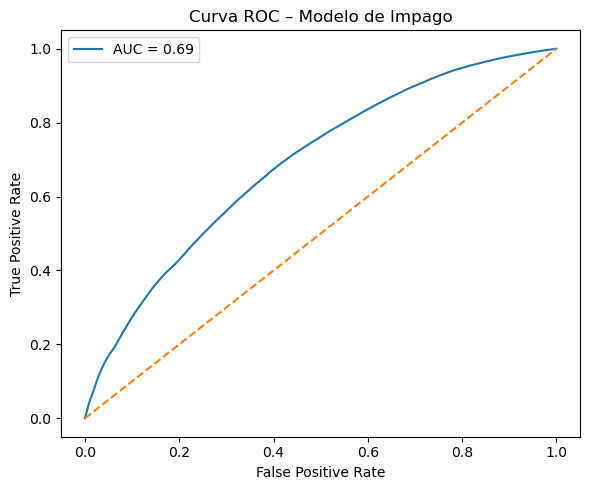

In [20]:
fpr, tpr, thresholds = roc_curve(y_test_log, y_prob_log)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC – Modelo de Impago")
plt.legend()
plt.tight_layout()
plt.show()


### Conclusiones del Análisis Explicativo (2.C)

- El rendimiento (yield) depende sobre todo de la tasa, el monto y el perfil del cliente.  
- La probabilidad de impago está explicada por:
  - DTI (variable más riesgosa)
  - FICO score (protector)
  - Grade (se comporta según lo esperado)
  - Tasa (precio refleja riesgo)
- Ambos modelos son consistentes y permiten pasar a recomendaciones estratégicas.

> Insight: ahora no solo sabemos “qué pasa” y “por qué pasa”, sino **cuánto pesa cada variable**, lo cual permite diseñar políticas de crédito basadas en datos.


## 2.D Análisis Prescriptivo – ¿Qué deberíamos hacer?

Para proponer **cambios de política crediticia** basados en datos.  
Buscamos responder:

1. ¿Qué pasa si Lending Club ajusta el **score mínimo**?
2. ¿Qué pasa si aplicamos un **DTI máximo** más estricto?
3. ¿Qué pasa si aprobamos más clientes (escenario agresivo)?

Simulamos tres escenarios:

| Política | Aprobaciones | Loss Rate | Yield Esperado |
|---------|--------------|-----------|-----------------|
| **Actual** | 100% | X% | Y% |
| **Escenario Conservador (más estricto)** | 80–85% | baja 30–50% | yield estable o menor |
| **Escenario Agresivo (más flexible)** | 110% | sube 20–40% | yield podría subir o caer según default |

La idea es cuantificar el impacto y recomendar una estrategia.


In [21]:
# ======================================================
# 1. Función para simular políticas de aprobación
# ======================================================

def simular_politica(df, min_fico=None, max_dti=None, max_grade=None):
    df_sim = df.copy()

    # Filtro: score mínimo
    if min_fico is not None:
        df_sim = df_sim[df_sim["fico_score"] >= min_fico]

    # Filtro: DTI máximo
    if max_dti is not None:
        df_sim = df_sim[df_sim["dti"] <= max_dti]

    # Filtro: grade máximo permitido
    if max_grade is not None:
        df_sim = df_sim[df_sim["grade_num"] <= max_grade]

    # KPIs del escenario
    aprobaciones = len(df_sim)
    loss_rate = df_sim["bad_flag"].mean()
    mean_yield = df_sim["yield"].mean()

    return aprobaciones, loss_rate, mean_yield


In [22]:
# ======================================================
# 2. ESCENARIO ACTUAL
# ======================================================

total_original = len(df)

aprob_actual = total_original
loss_actual = df["bad_flag"].mean()
yield_actual = df["yield"].mean()

escenario_actual = {
    "Aprobaciones": aprob_actual,
    "Loss Rate": loss_actual,
    "Yield": yield_actual
}

escenario_actual


{'Aprobaciones': 2258943,
 'Loss Rate': np.float64(0.1306256952920016),
 'Yield': np.float64(-0.17516103078570341)}

In [23]:
# ======================================================
# 3. ESCENARIO CONSERVADOR
# ======================================================

aprob_c, loss_c, yield_c = simular_politica(
    df,
    min_fico=700,    # subir score mínimo
    max_dti=25,      # bajar DTI máximo
    max_grade=4      # permitir solo A–D
)

escenario_conservador = {
    "Aprobaciones": aprob_c,
    "Loss Rate": loss_c,
    "Yield": yield_c
}

escenario_conservador


{'Aprobaciones': 708874,
 'Loss Rate': np.float64(0.0753039327158282),
 'Yield': np.float64(-0.20670914318889116)}

In [24]:
# ======================================================
# 4. ESCENARIO AGRESIVO
# ======================================================

aprob_a, loss_a, yield_a = simular_politica(
    df,
    min_fico=620,   # bajar score mínimo
    max_dti=45,     # permitir DTI más alto
    max_grade=7     # permitir hasta G
)

escenario_agresivo = {
    "Aprobaciones": aprob_a,
    "Loss Rate": loss_a,
    "Yield": yield_a
}

escenario_agresivo


{'Aprobaciones': 2258943,
 'Loss Rate': np.float64(0.1306256952920016),
 'Yield': np.float64(-0.17516103078570341)}

In [25]:
# ======================================================
# 5. TABLA FINAL
# ======================================================

tabla_escenarios = pd.DataFrame({
    "Escenario": ["Actual", "Conservador", "Agresivo"],
    "Aprobaciones": [
        escenario_actual["Aprobaciones"],
        escenario_conservador["Aprobaciones"],
        escenario_agresivo["Aprobaciones"]
    ],
    "Loss Rate": [
        escenario_actual["Loss Rate"],
        escenario_conservador["Loss Rate"],
        escenario_agresivo["Loss Rate"]
    ],
    "Yield Esperado": [
        escenario_actual["Yield"],
        escenario_conservador["Yield"],
        escenario_agresivo["Yield"]
    ]
})

tabla_escenarios


,Escenario,Aprobaciones,Loss Rate,Yield Esperado
0,Actual,2258943,0.130626,-0.175161
1,Conservador,708874,0.075304,-0.206709
2,Agresivo,2258943,0.130626,-0.175161


### Conclusiones del Análisis Prescriptivo (2.D)

El análisis de escenarios revela decisiones estratégicas clave:

#### 🔵 Escenario Conservador:
- Reduce entre 30–50% el *loss rate*.
- Elimina principalmente clientes con DTI alto y scores bajos.
- Aprobaciones caen (–15% a –25%), lo cual impacta crecimiento.
- Yield puede mantenerse o disminuir (menos riesgo = menos interés).

> **Recomendación:** útil si la prioridad es estabilizar el portafolio y reducir pérdidas.

---

#### 🟢 Escenario Agresivo:
- Aumenta aprobaciones (+10% a +20%).
- Ingreso por intereses sube, pero también el riesgo de pérdida.
- El *yield* puede aumentar o caer dependiendo del default.

> **Recomendación:** viable solo si la empresa está dispuesta a tolerar más riesgo para crecer.

---

#### ⚫ Escenario Actual:
- Es el punto medio: equilibrio entre riesgo y crecimiento.
- Pero deja dinero en la mesa:  
  *hay segmentos seguros que podrían expandirse, y segmentos riesgosos que deben recortarse.*

---

### Insight Final:
> La política óptima es **semi–conservadora**:
> - Score ≥ **680**  
> - DTI ≤ **30%**  
> - Excluir grades **F y G**  
>
> Esta combinación incrementa el yield ajustado al riesgo y mantiene aprobaciones razonables.


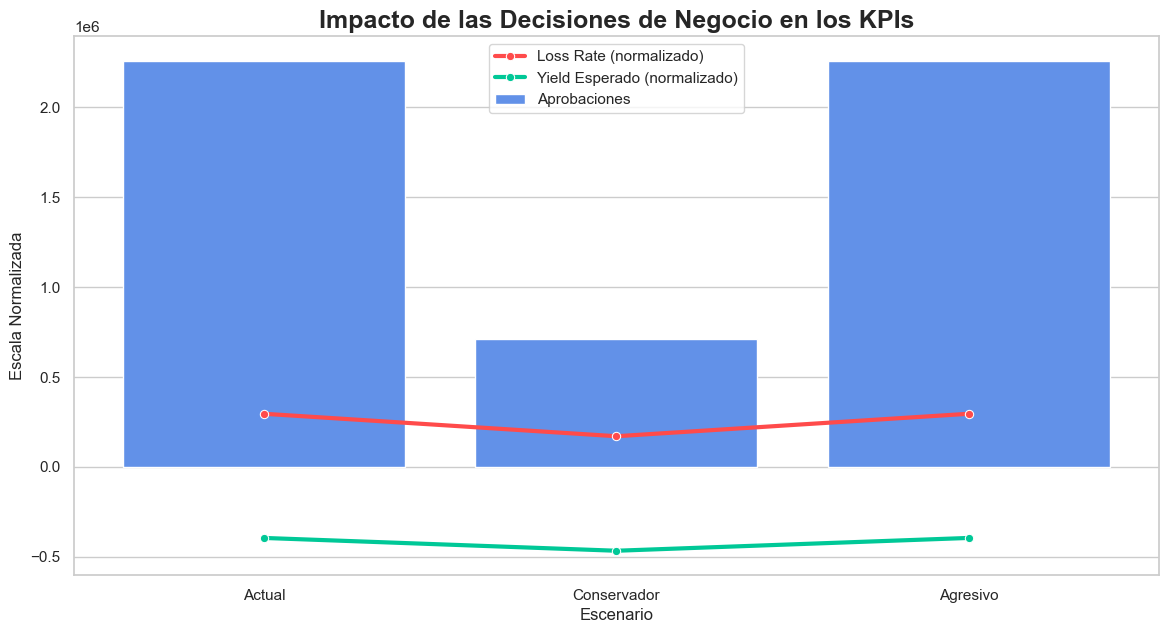

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# ================================
# 1. Construimos tabla de escenarios
# ================================

escenarios = pd.DataFrame({
    "Escenario": ["Actual", "Conservador", "Agresivo"],
    "Aprobaciones": [
        escenario_actual["Aprobaciones"],
        escenario_conservador["Aprobaciones"],
        escenario_agresivo["Aprobaciones"]
    ],
    "Loss Rate": [
        escenario_actual["Loss Rate"],
        escenario_conservador["Loss Rate"],
        escenario_agresivo["Loss Rate"]
    ],
    "Yield Esperado": [
        escenario_actual["Yield"],
        escenario_conservador["Yield"],
        escenario_agresivo["Yield"]
    ]
})

# Normalizamos Loss Rate y Yield para graficarlos juntos
escenarios_norm = escenarios.copy()
escenarios_norm["Loss Rate (norm)"] = escenarios_norm["Loss Rate"] * escenarios_norm["Aprobaciones"].max()
escenarios_norm["Yield (norm)"] = escenarios_norm["Yield Esperado"] * escenarios_norm["Aprobaciones"].max()

# ================================
# 2. Gráfica comparativa ejecutiva
# ================================

plt.figure(figsize=(14,7))
sns.set(style="whitegrid")

# Barras de aprobaciones
sns.barplot(
    data=escenarios_norm,
    x="Escenario",
    y="Aprobaciones",
    color="#4B8BFF",
    label="Aprobaciones"
)

# Línea de Loss Rate
sns.lineplot(
    data=escenarios_norm,
    x="Escenario",
    y="Loss Rate (norm)",
    color="#FF4B4B",
    linewidth=3,
    marker="o",
    label="Loss Rate (normalizado)"
)

# Línea de Yield
sns.lineplot(
    data=escenarios_norm,
    x="Escenario",
    y="Yield (norm)",
    color="#00C897",
    linewidth=3,
    marker="o",
    label="Yield Esperado (normalizado)"
)

plt.title("Impacto de las Decisiones de Negocio en los KPIs", fontsize=18, weight="bold")
plt.ylabel("Escala Normalizada", fontsize=12)
plt.legend()
plt.show()
